In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import sys
import os
from uni2ts.model.moirai_moe import MoiraiMoEForecast, MoiraiMoEModule


MODEL_PARAMS = {
"patch_size":16,  # 8, 16, 32, 64, 128
"num_samples": 100,
"target_dim": 1,
"feat_dynamic_real_dim": 0,
"past_feat_dynamic_real_dim": 0,
}

In [2]:
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), "scripts") )

from model_utils import generate_model_input, preprocess_data, get_predictions, plot_results, mean_absolute_percentage_error

root_path = os.path.dirname(os.getcwd())

# forecast with Moirai

total length: 4581
Index(['bitcoin_price'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

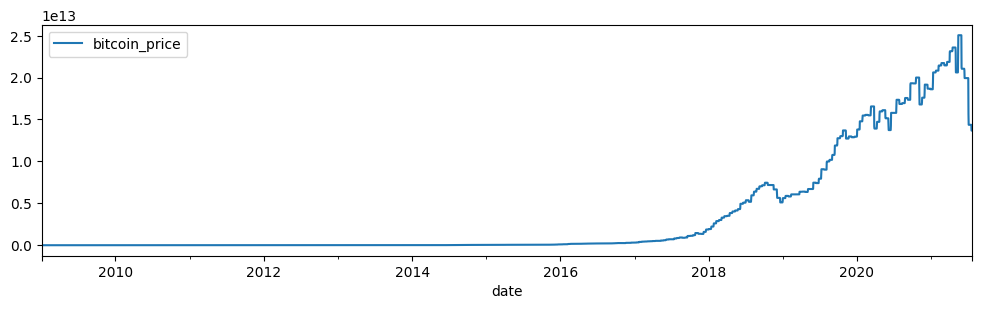

In [3]:
# First: Load dataframe and clean it
df = pd.read_csv(os.path.join(root_path, "data", "bitcoin_values.csv"), parse_dates=True)
date_colname= "date"
target_colname = "bitcoin_price"


df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)


print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))

torch.Size([1, 4380, 1])
torch.Size([1, 4380, 1])
torch.Size([1, 4380])


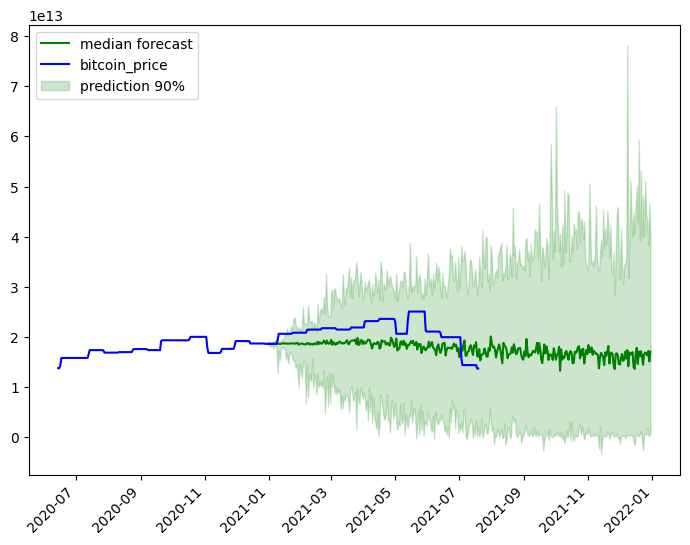

In [4]:
# create the train and test sets
train_window = 12 * 365 # days
prediction_window = 365  # days

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

# preprocess the data
target_tensor, is_target_observed, is_target_padded= preprocess_data(target=train[target_colname].values)

print(target_tensor.shape)
print(is_target_observed.shape)
print(is_target_padded.shape)

# Define the model
model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length= prediction_window,
    context_length=train_window,
    **MODEL_PARAMS,
)

# Make the forecast
forecast = model(
    past_target=target_tensor,
    past_observed_target=is_target_observed,
    past_is_pad=is_target_padded,
)

# Collect the median forecast and CI into a DataFrame
predictions_df = get_predictions(
    forecast_tensor=forecast[0],
    train_set=train,
    date_colname=date_colname
)

# Merge predictions with original data
true_and_preds = pd.merge(test, predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train.iloc[-200:, :], true_and_preds])

# Plot the results
figure = plot_results(results_df=all_data, target_colname=target_colname)
plt.show()

In [5]:
# Compute the forecast error
true_and_preds.dropna(inplace=True)
mae = mean_absolute_percentage_error(
    y_true=true_and_preds[target_colname].values,
    y_pred=true_and_preds["median_forecast"].values
)

print(mae)

14.690255292254928


## Rolling forecast using predictions

total length: 4581
Index(['bitcoin_price'], dtype='object')
time frequency: 1 days 00:00:00
2009-01-03 00:00:00 2021-07-19 00:00:00


<Axes: xlabel='date'>

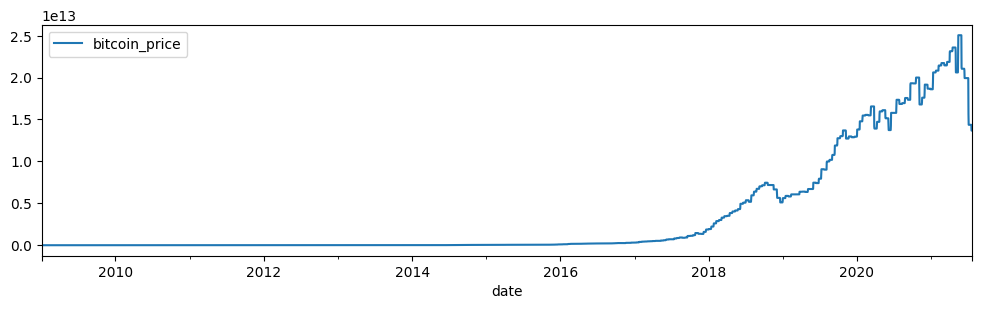

In [6]:
# First: Load dataframe

df = pd.read_csv(os.path.join(root_path, "data", "bitcoin_values.csv"), parse_dates=True)
date_colname= "date"
target_colname = "bitcoin_price"

df[date_colname] = pd.to_datetime(df[date_colname])
df.set_index(date_colname, inplace=True)

print(f"total length: {df.shape[0]}")
print(df.columns)
print(f"time frequency: {df.index.diff()[1]}")
print(df.index[0], df.index[-1])
df.plot(figsize=(12, 3))


In [7]:
# create the train and test sets
train_window =   12 * 365  #2 * 365 # days
prediction_window = 30  # days
niter = 13  # iterations for the rolling forecast

train = df.iloc[:train_window, :].copy()
test = df.iloc[train_window:, :].copy()

train_original = train.copy()  # to be used for plotting

# Rolling forecast
all_predictions = []
for i in range(niter):
    print(f"interation: {i}")
    if i == 0:
        # Use the original train
       train = generate_model_input(train_df=train, date_colname=date_colname, target_colname=target_colname, median_forecast=None)

    elif last_date_train + frequency * prediction_window in test.index:
        # In case you receive new input data (here represented by the test)
        train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=test.loc[last_date_train + frequency: last_date_train + frequency * prediction_window, target_colname].values
       )

    else:
        # Use forecast to create another forecast
       train = generate_model_input(
           train_df=train,
           date_colname=date_colname,
           target_colname=target_colname,
           median_forecast=predictions_df["median_forecast"].values
       )

    # Preprocess the new train set
    target_tensor, is_target_observed, is_target_padded = preprocess_data(
        target=train[target_colname].values
    )

    # Prepare model
    model = MoiraiMoEForecast(
    module=MoiraiMoEModule.from_pretrained(f"Salesforce/moirai-moe-1.0-R-small"),
    prediction_length=prediction_window,
    context_length=train_window+i*prediction_window,  # Train context is not rolling, it always stars from the beginning
    **MODEL_PARAMS,
    )

    forecast = model(
        past_target=target_tensor,
        past_observed_target=is_target_observed,
        past_is_pad=is_target_padded,
    )

    predictions_df= get_predictions(
        forecast_tensor=forecast[0],
        train_set=train,
        date_colname=date_colname
    )
    last_date_train = predictions_df.index[-1]
    frequency = predictions_df.index.diff()[1]

    all_predictions.append(predictions_df)

all_predictions_df = pd.concat(all_predictions)


4380 days
interation: 0
interation: 1
interation: 2
interation: 3
interation: 4
interation: 5
interation: 6
interation: 7
interation: 8
interation: 9
interation: 10
interation: 11
interation: 12


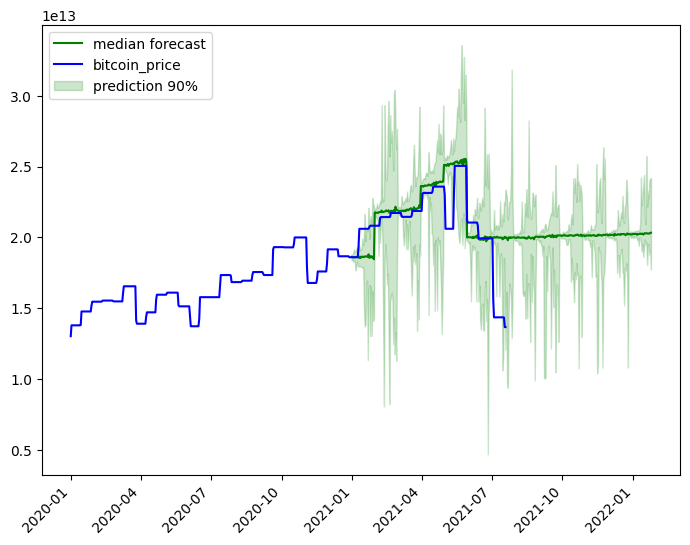

In [8]:
true_and_preds = pd.merge(test, all_predictions_df, left_index=True, right_index=True, how="right")
all_data = pd.concat([train_original.iloc[train_window-365:, :], true_and_preds])

figure = plot_results(results_df=all_data, target_colname=target_colname)
plt.show()